# Numerical Solutions to the Advection Eqaution in 1-D

## Mathematical Problem

The homogenous advection equation in one dimmension is  
\begin{align}
  \frac{\partial u}{\partial t} = a \frac{\partial u}{\partial x}
\end{align}
where $u(x,t)$ is a scalar field (_e.g._ density, enthalpy) and $a$ is the advection velocity. This hyperbolic equation is simple very useful for insight on how to numerically solve hyperbolic PDEs. In order to solve this equation (numerically or analytically) we need inital conidtions at $t_0$  
\begin{align}
  u(x,t_0) = \eta(x)
\end{align}
and boundary conditions  
\begin{align}
\begin{aligned}
  u(0, t) = g_0(t) \;\;\; \text{for} \;\;\; t>0\\
  u(L, t) = g_0(t) \;\;\; \text{for} \;\;\; t>0
\end{aligned}
\end{align}  
on the domain $0<x<L$.

## Numerical Approaches
We will aplly finite differences on a discrete grid with grid points $(x_i, t_j)$ where  
\begin{align}
  x_i = i h && t_j = jk
\end{align}
Here $h = \Delta x$ is the grid cell spacing and $k = \Delta t$ is the time step, with $U^i_j \approx u(x_i, t_j)$ is numerical approximation at $(x_i, t_j)$.  

__Foward-Time Cenetered-Space (FTCS)__  

A first order approach, using centered differences in space 
\begin{align}  
  \frac{U_i^{j+1} - U_i^{j}}{\Delta t} = -\frac{a}{2 \Delta x} \left( U_{i+1}^{j} + U_{i-1}^{j}\right)
\end{align}  
and forward differences in time, can be written as   
\begin{align}  
  U_i^{j+1} = U_i^{j} -\frac{a \Delta t}{2 \Delta x} \left( U_{i+1}^{j} + U_{i-1}^{j}\right) . 
\end{align} 
This method is not useful because of stability limitations and is only first order accurate. We will not use this in practice, but usefull for comparison to more accurate and stable methods.  

__Lax-Wendroff__   
This method is based on the Taylor series expansion  
\begin{align}
  u(x,t_{j+1}) = u(x,t_{j}) + \Delta u_t(x,t_n) + \frac12 (\Delta t)^2 u_{tt}(x,t_n) + \ldots.
  \label{eqn:taylor}
\end{align}  
From the governing equation we have $u_t = a u_x$, differentiating this with respect to $t$ gives  
\begin{align}  
  u_{tt} = -au_{xt} = a^2 u_{xx}
\end{align}
where we have used $u_{xt} = u_{tx} = (a u_x)_x $ based on equality of mixed derivatives. Subing these expressions for $u_t$ and $u_tt$ into Eqn. \ref{eqn:taylor} gives  
\begin{align}
  u(x,t_{j+1}) = u(x,t_{j}) + \Delta t \; au_x(x,t_n) + \frac12 (\Delta t)^2 a^2 u_{xx}(x,t_n) + \ldots.
\end{align}
Using only these first three terms and expanding the spatial derivatives using centered differences gives
\begin{align}  
  U_i^{j+1} = U_i^{j} -\frac{ \Delta t}{2 \Delta x} a \left( U_{i+1}^{j} + U_{i-1}^{j}\right) + \frac{(\Delta t)^2}{2 (\Delta x)^2} a^2 \left(U_{i-1}^{j} -2U_{i}^{j} + U_{i+1}^{j}\right). 
\end{align} 
the _Lax-Wendroff_ method, which is second order accurate. 


__Upwind__  
The above methods are symetric in space, but the advection equation is aysymettric depending on the sign of $a$; if $a > 0$ the solution moves to the right and if $a<0$ the solution moves to the left. Therefore, under special circumstances when the solution is asymetteric we can take advantage of this  
\begin{align}  
  U_i^{j+1} = U_i^{j} -\frac{a \Delta t}{\Delta x} \left( U_{i}^{j} - U_{i-1}^{j}\right) 
\end{align} 
or   
\begin{align}  
  U_i^{j+1} = U_i^{j} -\frac{a \Delta t}{\Delta x} \left( U_{i+1}^{j} - U_{i}^{j}\right) 
\end{align} 

__Beam-Splitting__  
\begin{align}  
  U_i^{j+1} = U_i^{j} -\frac{ \Delta t}{2 \Delta x} a \left( 3U_{i}^{j} - 4U_{i-1}^{j} + U_{i-2}^{j}\right) + \frac{(\Delta t)^2}{2 (\Delta x)^2} a^2 \left(U_{i}^{j} -2U_{i-1}^{j} + U_{i-2}^{j}\right). 
\end{align} 


## Python Implementation

In [1]:
# Global
import sys 
import numpy as np 
import matplotlib.pyplot as plt

# Local
sys.path.append('../')
from advdiff.solvers import TDMA
from advdiff.plot import animation

In [19]:
def gauss(x, σ = 0.05, μ = 0.5):
    '''1-D Gaussian Curve
    
    Keyword arguments:
    σ -- σ^2 is the variance
    μ -- Mean (i.e. center) 
    '''
    return 1./(σ*(2*np.pi)**0.5)*np.exp(-0.5*((x-μ)/σ)**2)

########################################################
#################   Init. Constant   ###################
########################################################
a  = 3                     # wave speed 
L  = 1.                    # Domain Length 
nx = 100                   # Num. grid cells
dx = L/(nx-1)              # grid spacing

nt = 1000                   # Num time steps
σ  = .75                   # courant number
dt = 2e-3 #(σ*dx)**2/a           # time step 

########################################################
##################   Init. Domain   ####################
########################################################
x  = np.linspace(dx,L,nx)  # spatial grid
u  = np.zeros((5,nx,nt+1)) # (num methods) X (nx) X (nt)
u[:,:,0] = gauss(x)        # init. condition

for j in range(1,nt):
    for i in range(1,nx-1):  
        # FTCS (0)
        u[0,i,j+1] = u[0,i,j] - ((dt*a)/(dx*2)) * (u[0,i+1,j] - u[0,i-1,j])
        # Up-wind (1)
        u[1,i,j+1] = u[1,i,j] - ((dt*a)/dx)* (u[1,i,j] - u[1,i-1,j]) 
        # Lax-Wendroff (2)
        u[2,i,j+1] = u[2,i,j] - ((dt*a)/(dx*2))* (u[2,i+1,j] - u[2,i-1,j]) + ((dt*a)**2/(2*dx**2))*(u[2,i+1,j] - 2*u[2,i,j] + u[2,i-1,j])
        # Beam-Splitting (3)
        u[3,i,j+1] = u[3,i,j] - ((dt*a)/(dx*2))* (3*u[3,i,j] - 4*u[3,i-1,j] + u[3,i-2,j]) + ((dt*a)**2/(2*dx**2))*(u[3,i,j] - 2*u[3,i-1,j] + u[3,i-2,j])
        
    #Anlytical (4)
    u[4,:,j] = gauss(x-a*(j*dt))        # init. condition
        
    
    u[:,0,j+1]  = u[:,-2,j+1]
    u[:,-1,j+1]  = u[:,1,j+1]


In [25]:
def periodically_continued(a, b):
    interval = b - a
    return lambda f: lambda x: f((x - a) % interval + a)

@periodically_continued(-1, 1)
def f(x):
    return (1/(σ*(2*np.pi)**0.5)) * np.exp(-0.5*(((x-a*j)-μ)/σ)**2)

g = periodically_continued(0, 1)(lambda x: -x)

assert f(2.5) == 0.5
assert g(2.5) == -0.5

AssertionError: 

In [26]:
x % L

array([0.01010101, 0.02009999, 0.03009897, 0.04009795, 0.05009693,
       0.06009591, 0.07009489, 0.08009387, 0.09009285, 0.10009183,
       0.11009081, 0.12008979, 0.13008877, 0.14008775, 0.15008673,
       0.16008571, 0.17008469, 0.18008366, 0.19008264, 0.20008162,
       0.2100806 , 0.22007958, 0.23007856, 0.24007754, 0.25007652,
       0.2600755 , 0.27007448, 0.28007346, 0.29007244, 0.30007142,
       0.3100704 , 0.32006938, 0.33006836, 0.34006734, 0.35006632,
       0.3600653 , 0.37006428, 0.38006326, 0.39006224, 0.40006122,
       0.4100602 , 0.42005918, 0.43005816, 0.44005714, 0.45005612,
       0.4600551 , 0.47005408, 0.48005306, 0.49005204, 0.50005102,
       0.51004999, 0.52004897, 0.53004795, 0.54004693, 0.55004591,
       0.56004489, 0.57004387, 0.58004285, 0.59004183, 0.60004081,
       0.61003979, 0.62003877, 0.63003775, 0.64003673, 0.65003571,
       0.66003469, 0.67003367, 0.68003265, 0.69003163, 0.70003061,
       0.71002959, 0.72002857, 0.73002755, 0.74002653, 0.75002

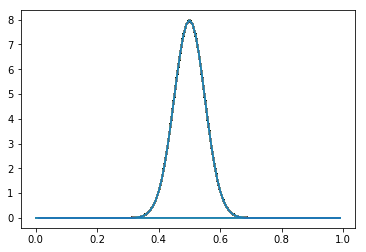

In [87]:
test= lambda x,t : (1/(σ*(2*np.pi)**0.5)) * np.exp(-0.5*(((x -a*t)-μ)/σ)**2)

for j in np.linspace(1,nt*dt,nt):
    x = x % L
    new = gauss(x) + gauss(x)
    plt.plot(x,gauss(x))

In [48]:
def periodically_continued(a, b):
    interval = b - a
    return lambda f: lambda x,j: f((x - a) % interval + a)

@periodically_continued(-1, 1)
def f(x,j):
    σ = 0.05
    μ = 0.5
    a = 3
    return (1/(σ*(2*np.pi)**0.5)) * np.exp(-0.5*(((x-a*j)-μ)/σ)**2)

assert f(2.5,9) == 0.5


TypeError: <lambda>() takes 1 positional argument but 2 were given

http://ramanujan.math.trinity.edu/rdaileda/teach/s14/m3357/lectures/lecture_1_21_slides.pdf

In [77]:
t

999

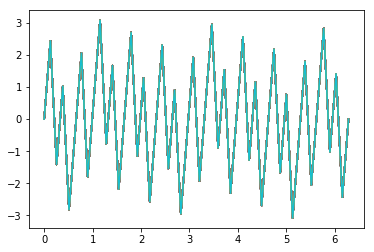

In [58]:
for i in range(0,100):
    plt.plot(np.linspace(0,2*pi), f(np.linspace(0,2*pi),t))

https://stackoverflow.com/questions/32669101/how-to-define-periodic-function-in-python
https://flipdazed.github.io/blog/python/periodic-boundary-conditions
https://stackoverflow.com/questions/26022500/implementation-of-periodic-gaussian
https://scicomp.stackexchange.com/questions/20113/periodic-boundary-condition-for-the-heat-equation-in-0-1

In [63]:
x % L - L

array([-0.98989899, -0.97990001, -0.96990103, -0.95990205, -0.94990307,
       -0.93990409, -0.92990511, -0.91990613, -0.90990715, -0.89990817,
       -0.88990919, -0.87991021, -0.86991123, -0.85991225, -0.84991327,
       -0.83991429, -0.82991531, -0.81991634, -0.80991736, -0.79991838,
       -0.7899194 , -0.77992042, -0.76992144, -0.75992246, -0.74992348,
       -0.7399245 , -0.72992552, -0.71992654, -0.70992756, -0.69992858,
       -0.6899296 , -0.67993062, -0.66993164, -0.65993266, -0.64993368,
       -0.6399347 , -0.62993572, -0.61993674, -0.60993776, -0.59993878,
       -0.5899398 , -0.57994082, -0.56994184, -0.55994286, -0.54994388,
       -0.5399449 , -0.52994592, -0.51994694, -0.50994796, -0.49994898,
       -0.48995001, -0.47995103, -0.46995205, -0.45995307, -0.44995409,
       -0.43995511, -0.42995613, -0.41995715, -0.40995817, -0.39995919,
       -0.38996021, -0.37996123, -0.36996225, -0.35996327, -0.34996429,
       -0.33996531, -0.32996633, -0.31996735, -0.30996837, -0.29